Валидация модели детекции терминалов

# Загрузка библиотек

In [132]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка модели и валидация

In [3]:
model_terminal = YOLO('model_terminal_detection.pt')

In [4]:
df_val = pd.read_pickle("df_val.pkl")

In [5]:
preds, labels = [], []
for row in tqdm(df_val.iterrows()):
    row = row[1]
    pred = model_terminal.predict(row['filename'], verbose=False)
    preds.append(np.unique(pred[0].boxes.cls.numpy()))
    labels.append(row['flags'])

1200it [07:55,  2.52it/s]


In [84]:
preds_str = []
for label, pred in tqdm(zip(labels, preds)):
    if pred.shape[0]==0:
        preds_str.append('nothing')
        continue
    if pred[0]==0:
        preds_str.append('terminals')
        continue
    if pred[0]==1:
        preds_str.append('pax_im20')
        continue
    if pred[0]==2:
        preds_str.append('new_terminals')

1200it [00:00, 1351548.01it/s]


In [125]:
df_val.iloc[
    np.where(np.array(preds_str)=='pax_im20')[0], 1
] = 'pax_im20'

In [129]:
cm = confusion_matrix(
    df_val['flags'], preds_str, labels=list(set(preds_str) | set(df_val['flags']))
)

In [135]:
df_cm = pd.DataFrame(
    cm, columns=list(set(preds_str) | set(df_val['flags'])),
    index=list(set(preds_str) | set(df_val['flags']))
)
df_cm = df_cm.replace(0, np.nan).dropna(axis=1, how="all").fillna(0)
df_cm = df_cm.loc[~(df_cm==0).all(axis=1)]
df_cm = df_cm.astype(int)
df_cm

,new_terminals,nothing,pax_im20,terminals
new_terminals,44,0,0,0
receipts,0,541,0,0
pc_screens,0,90,0,0
pax_im20,0,0,4,0
other,0,60,0,0
stickers,0,28,0,0
rack_new_terminal,0,14,0,0
terminals_side_view,0,61,0,3
terminals,0,0,0,355


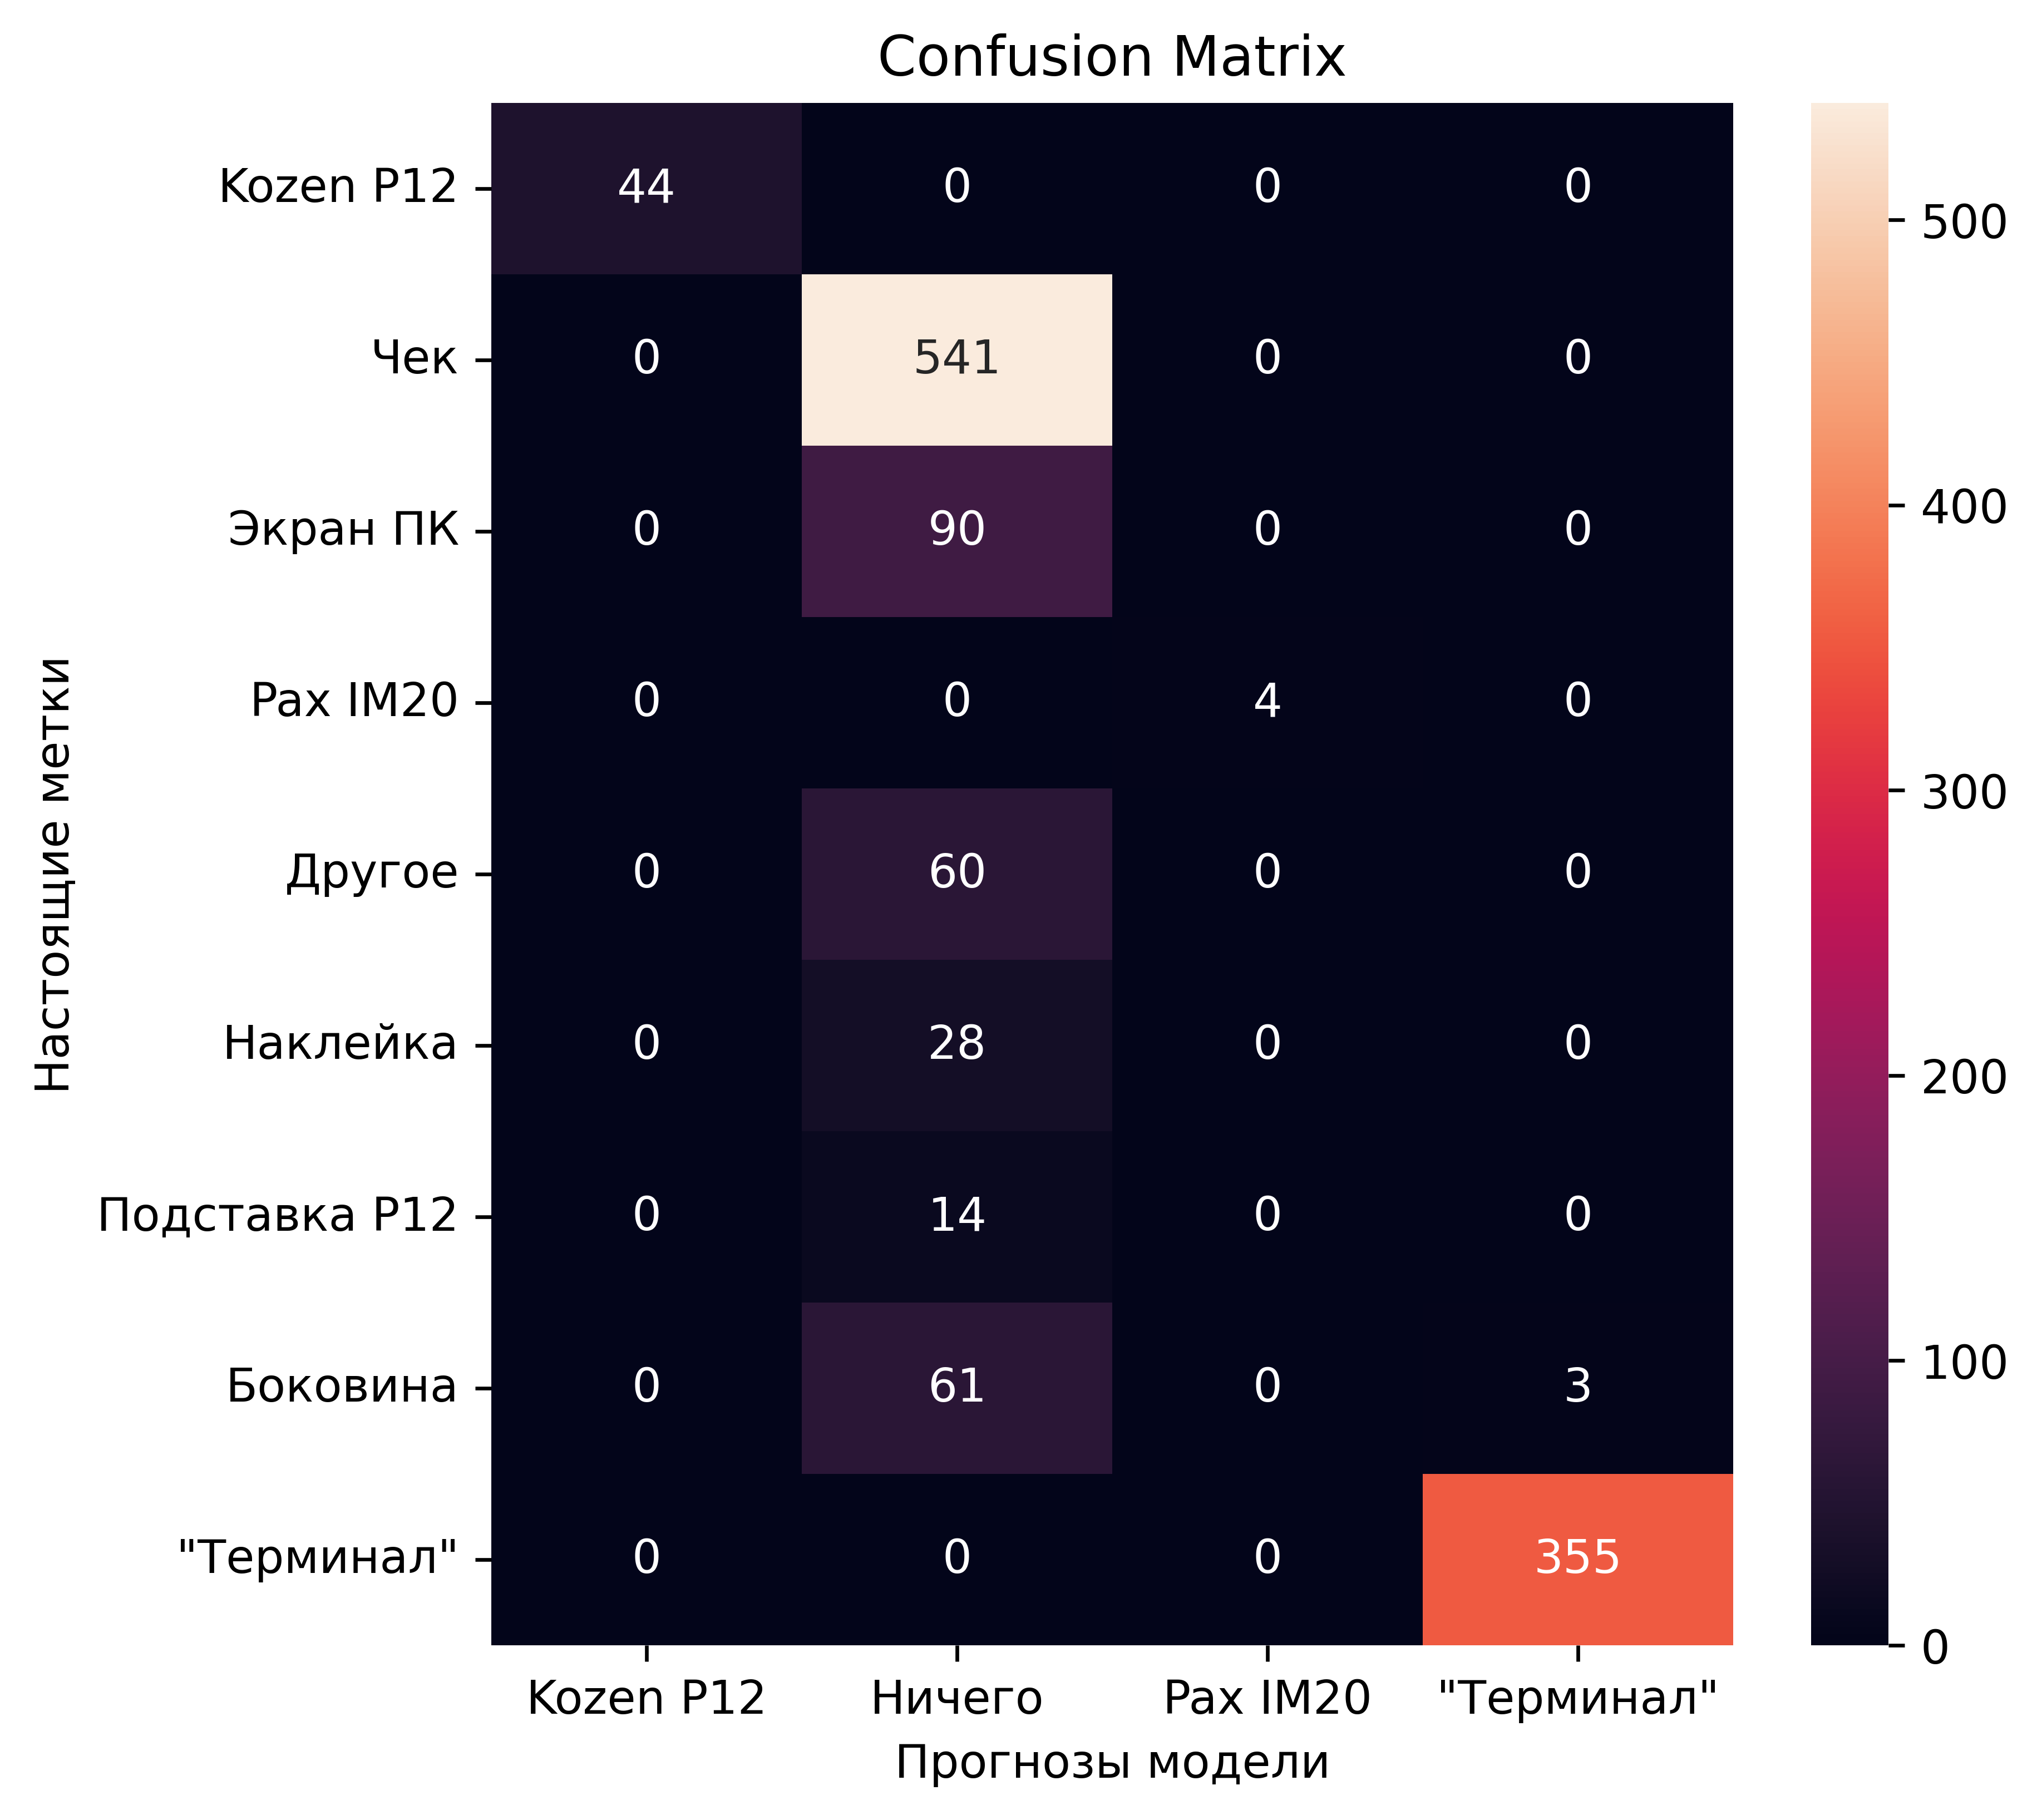

In [140]:
y_labels = ['Kozen P12', 'Чек', 'Экран ПК', 'Pax IM20', 'Другое', 'Наклейка', 'Подставка P12', 'Боковина', '"Терминал"']
x_labels = ['Kozen P12', 'Ничего', 'Pax IM20', '"Терминал"']
plt.figure(figsize=(6, 6), 
           dpi = 600)
sns.heatmap(df_cm, annot=True, fmt='d',
            xticklabels=x_labels, yticklabels=y_labels, )
plt.title('Confusion Matrix')
plt.xlabel('Прогнозы модели')
plt.ylabel('Настоящие метки')
plt.show()